In [ ]:
#Mohammed Alom R00144214

#Importing required models
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Embedding,GRU,LSTM,Bidirectional,Dropout,Conv1D,MaxPooling1D
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import EarlyStopping
from keras import regularizers

from sklearn.ensemble import VotingClassifier
from sklearn import model_selection
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics

import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import codecs
from gensim.models import Word2Vec
import tensorflow as tf

In [ ]:
#Connecting with the google drive and finding out the number of GPU available
print("Number of GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
from google.colab import drive
drive.mount('/content/gdrive')

Number of GPUs Available:  1
Mounted at /content/gdrive


In [ ]:
#Allocating the target class and initializing the variables
target_class = ['ALE', 'ALG', 'ALX', 'AMM', 'ASW', 'BAG', 'BAS', 'BEI', 'BEN',
                      'CAI', 'DAM', 'DOH', 'FES', 'JED', 'JER', 'KHA', 'MOS', 'MSA',
                      'MUS', 'RAB', 'RIY', 'SAL', 'SAN', 'SFX', 'TRI', 'TUN']
max_features = 10000
max_len = 100
batch_size = 32
epochs = 10

# loading the data file form google drive
train_file ='/content/gdrive/My Drive/Colab Notebooks/nlp-data/MADAR-Corpus-26-train.tsv'
dev_file ='/content/gdrive/My Drive/Colab Notebooks/nlp-data/MADAR-Corpus-26-dev.tsv'

#train_file ='/content/gdrive/My Drive/Colab Notebooks/nlp-data/MADAR-Corpus-6-train.tsv'
#dev_file ='/content/gdrive/My Drive/Colab Notebooks/nlp-data/MADAR-Corpus-6-dev.tsv'

#pre trained models
model_dir = '/content/gdrive/My Drive/Colab Notebooks/nlp-data/model/full_uni_cbow_100_wiki.mdl'
#model_dir = '/content/gdrive/My Drive/Colab Notebooks/nlp-data/model/full_grams_cbow_100_wiki.mdl'

#model_dir = '/content/gdrive/My Drive/Colab Notebooks/nlp-data/model/full_grams_cbow_300_twitter.mdl'
#model_dir = '/content/gdrive/My Drive/Colab Notebooks/nlp-data/model/full_uni_sg_300_twitter.mdl'

In [ ]:
def prepare_data(data_dir):
    labels = []
    texts = [] 
    for label_type in target_class:#categories
        dir_name = os.path.abspath(train_file)
        f = codecs.open(os.path.abspath(train_file), encoding='utf8')
        texts.append(f.read())# add the sentences to text array
        f.close()
        #value to assign to every class
        if label_type in ['MSA']:  
            labels.append(0)
        elif label_type in ['BEI']: 
            labels.append(1)
        elif label_type in ['DOH']: 
            labels.append(2)
        elif label_type in ['RAB']: 
            labels.append(3)
        elif label_type in ['CAI']: 
            labels.append(4)
        elif label_type in ['TUN']:
            labels.append(5)       
        elif label_type in ['ALE']:
            labels.append(6)           
        elif label_type in ['ALG']:
            labels.append(7)
        elif label_type in ['ALX']:
            labels.append(8)
        elif label_type in ['AMM']:
            labels.append(9)
        elif label_type in ['ASW']:
            labels.append(10)
        elif label_type in ['BAG']:
            labels.append(11)
        elif label_type in ['BAS']:
            labels.append(12)
        elif label_type in ['BEN']:
            labels.append(13)
        elif label_type in ['DAM']:
            labels.append(14)
        elif label_type in ['FES']:
            labels.append(15)
        elif label_type in ['JED']:
            labels.append(16)
        elif label_type in ['JER']:
            labels.append(17)
        elif label_type in ['KHA']:
            labels.append(18)
        elif label_type in ['MOS']:
            labels.append(19)
        elif label_type in ['MUS']:
            labels.append(20)
        elif label_type in ['RIY']:
            labels.append(21)
        elif label_type in ['SAL']:
            labels.append(22)
        elif label_type in ['SAN']:
            labels.append(23)
        elif label_type in ['SFX']:
            labels.append(24)
        elif label_type in ['TRI']:
            labels.append(25)
    return texts, labels

In [ ]:
def load_data(data_dir, maxlen,max_words, test= False ):
#train_directory  
    labels = []
    texts = []
    #calling prepare_data function
    texts, labels = prepare_data(data_dir)

    #spliting and tokenize the data
    tokenizer = Tokenizer(num_words=max_words,split=' ')
    #list of texts
    tokenizer.fit_on_texts(texts)
    sequences = tokenizer.texts_to_sequences(texts)
    word_index = tokenizer.word_index
    print('Found %s total unique tokens.' % len(word_index))

    #ensure all the sentences have the same length
    data = pad_sequences(sequences, maxlen=maxlen)
    #converting the leves to an array
    labels = np.asarray(labels)
    print('Shape of data tensor:', data.shape)
    print('Shape of label tensor:', labels.shape)

    indices = np.arange(data.shape[0])
    np.random.shuffle(indices)
    data = data[indices]
    labels = labels[indices]
    x_data = data[:]
    if test:
        y_data = np.asarray(labels) 
    else:
        y_data = labels[:]
        #converting the vector to binary matrix
    y_data = to_categorical(y_data, num_classes=len(target_class))
    return x_data, y_data

In [ ]:
#Finding the total train and test shape of the data
input_train, y_train = load_data(train_file,max_len,max_features)
input_test, y_test = load_data(dev_file,max_len,max_features,test= True)
print('Total input_train shape:', input_train.shape)
print('Total input_test shape:', input_test.shape)

Found 27528 total unique tokens.
Shape of data tensor: (26, 100)
Shape of label tensor: (26,)
Found 27528 total unique tokens.
Shape of data tensor: (26, 100)
Shape of label tensor: (26,)
Total input_train shape: (26, 100)
Total input_test shape: (26, 100)


In [ ]:
#Building the prebuild keras LStM model
def build_keras_model_LSTM(max_len, max_features):
    model = Sequential()
    #converting the low dimentional space to high dimentional vectors
    #change the embedding dim which is model length 
    model.add(Embedding(max_features, 100, input_length= max_len))
    model.add(Bidirectional(LSTM(32)))
    #randomly drop units from the neural network during training
    model.add(Dropout(0.25))
    #Optimizing the model
    model.add(Dense(len(target_class), activation='sigmoid',kernel_regularizer=regularizers.l2(0.01),
            activity_regularizer=regularizers.l1(0.01)))
    model.summary()
    model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['acc'])
    print(model.summary())
    return model

In [ ]:
model_LSTM = build_keras_model_LSTM(max_len, max_features)
#Specify the performance mesuare to monitor
early_stopping = EarlyStopping(monitor='val_loss', patience=2)
history_LSTM = model_LSTM.fit(input_train, y_train,
                    epochs=100,
                    batch_size=batch_size,
                    callbacks=[early_stopping],
                    validation_split=0.2)
model = model_LSTM
history = history_LSTM

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          1000000   
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                34048     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 26)                1690      
Total params: 1,035,738
Trainable params: 1,035,738
Non-trainable params: 0
_________________________________________________________________
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          1000000   
__________________________

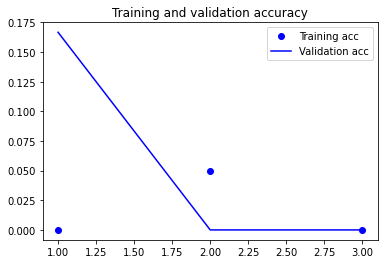

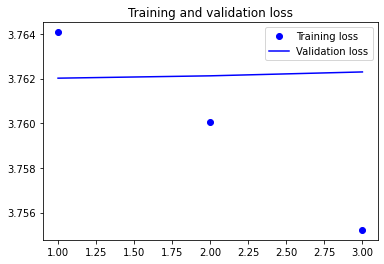

1/1 - 0s
              precision    recall  f1-score   support

         ALE       0.00      0.00      0.00         1
         ALG       0.00      0.00      0.00         1
         ALX       0.00      0.00      0.00         1
         AMM       0.00      0.00      0.00         1
         ASW       0.00      0.00      0.00         1
         BAG       0.00      0.00      0.00         1
         BAS       0.00      0.00      0.00         1
         BEI       0.00      0.00      0.00         1
         BEN       0.00      0.00      0.00         1
         CAI       0.00      0.00      0.00         1
         DAM       0.00      0.00      0.00         1
         DOH       0.00      0.00      0.00         1
         FES       0.00      0.00      0.00         1
         JED       0.00      0.00      0.00         1
         JER       0.00      0.00      0.00         1
         KHA       0.00      0.00      0.00         1
         MOS       0.00      0.00      0.00         1
         MSA      

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
def plot_show(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

plot_show(history)
scores= model.evaluate(input_test, y_test,verbose=0)
predicte = model.predict(input_test, verbose = 2, batch_size = batch_size)
print(metrics.classification_report(y_test.argmax(axis=1), np.argmax(predicte[:,:],axis=1),target_names = target_class))
print("Accuracy: %.2f%%" % (scores[1]*100))

#from sklearn.metrics import f1_score
#metrics.f1_score(y_test, predicte, labels=np.unique(predicte))

In [ ]:
def plot_confusion_matrix(score, cm, title='Confusion matrix', cmap=plt.cm.Greys):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(set(score)))
    plt.xticks(tick_marks, score, rotation=45)
    plt.yticks(tick_marks, score)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return plt

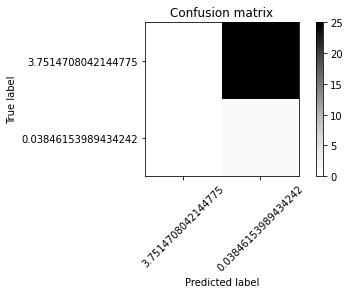

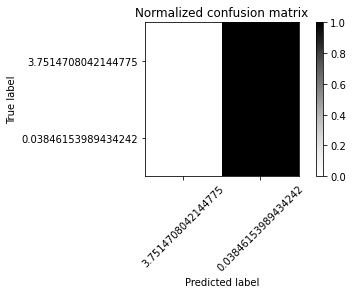

In [ ]:
cm = metrics.confusion_matrix(y_test[:,1], np.round(predicte[:,1]))
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(scores,cm).show    
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure()
plot_confusion_matrix(scores,cm_normalized, title='Normalized confusion matrix').show
plt.show()

0.038461538461538464
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

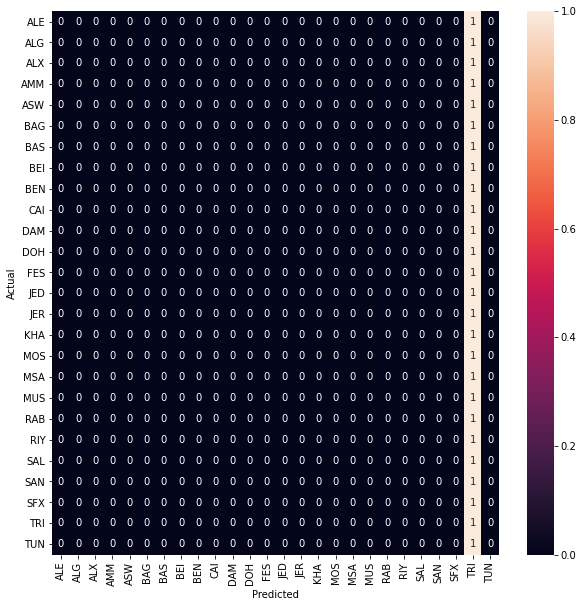

In [ ]:
predicted = model.predict(input_test)
predicted = np.argmax(predicted, axis=1)
accuracy_score(y_test.argmax(axis=1), predicted)
print(accuracy_score(y_test.argmax(axis=1), predicted))
matrix = metrics.confusion_matrix(y_test.argmax(axis=1), predicted)
print(matrix)
scores= model.evaluate(input_test, y_test,verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))
conf_mat = metrics.confusion_matrix(y_test.argmax(axis=1), predicted)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=target_class, yticklabels=target_class)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()